<a href="https://colab.research.google.com/github/limesoda314/cutiehack2021/blob/main/cutie_hack_2021_train_and_save_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cutie Hack 2021 
Our project will allow a user to draw a number and then have the program attempt to classify it. This jupyter notebook will allow us to save a CNN model that is trained on the mnist dataset. We are using keras with a tensorflow backend to create our classification model. We are using a Convolutional Neural Network since this will allow us to get more accurate results that we can save and use in our project.

In [95]:
from google.colab import drive
drive.mount('/content/drive/')
# since we want to save the model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [96]:
%tensorflow_version 2.x
import tensorflow as tf
# making sure we are using the correct version of tensorflow

# Importing libraries 

In [126]:
import keras                          # what we're using to create the model 
from keras.models import Sequential   # the model type that we're using 
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization    # these are the layers that we will be using later in our CNN 
from keras import backend as k        # this is to make sure we are using the correct color channels 
from keras import models              # this will allow us to save our model 

import pandas as pd                   # for the pandas dataframes
import numpy as np                    # we'll be using this for one hot encoding 
import matplotlib.pyplot as plt       # this is used for plotting 
import seaborn as sns                 # prettier plotting than pyplot

# improve formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

# Importing MNIST dataset

Keras already provides us the MNIST dataset. As such we are going to split this into 2 datasets: test and train.

The x stands for our data or images and the y is our target or labels (the digit names). 

In [121]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Initial shape of our training and test sets

As you can tell we are supplying our model with 60,000 sample images of 28x28 pixels and we have a test set of 10,000 images.




In [99]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test:  {}".format(x_test.shape))
print("y_test:  {}".format(y_test.shape))

x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


# Viewing the dataset

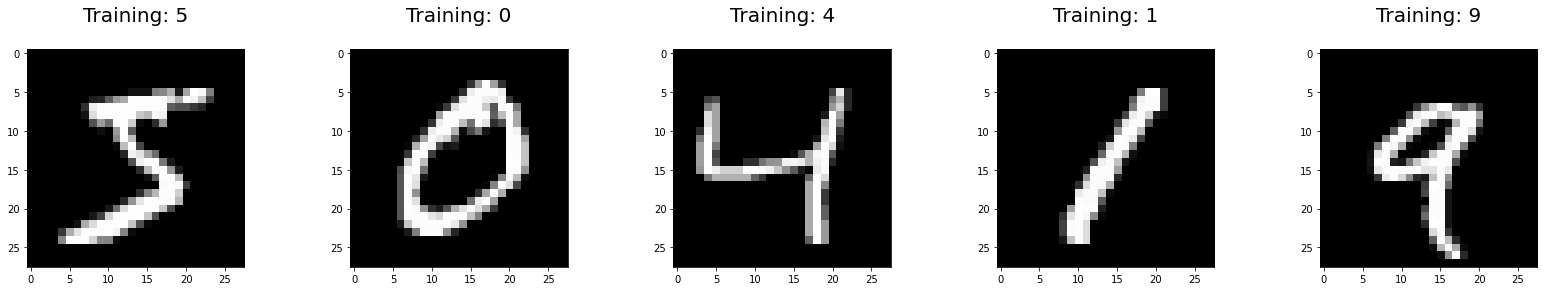

In [100]:
plt.figure(figsize=(28,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
  plt.subplot(1, 5, index + 1)
  plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
  plt.title('Training: %i\n' % label, fontsize = 20)

# One Hot Encoding
In the following lines of code we are converting the target datasets to use one-hot encoding. In one-hot encoding, we convert each class a binary array where we have 0 to represent that it is not that class and 1 to represent that it is. 

In [101]:
# before one hot encoding 
print("y_train[0]:", y_train[0])

y_train[0]: 5


In [102]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [103]:
# after one hot encoding
print("y_train[0]:", y_train[0])

y_train[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


To convert our data back to what we had earlier we can just do the following line:

```
y_test = np.argmax(y_test, axis=1)
```

# Reshaping our data
Each image in our x_train dataset is stored as an array of pixel values which can be a number from 0-255. Now how does that affect us? If we were to directly train a model using the dataset as is, we could have a very skewed representation since we could have most of our values within a small range and then have 2-3 outliers. Our model will also train faster if the values are within a smaller range. 

As a result, we want to standardize our dataset such that we have values from 0-1. To do this we can just divide by 255. However in doing so, we want to make sure that we get decimal values since doing integer division will give us a value that is either 0 or 1.

In [130]:
x_train[1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  54, 227, 253, 252, 239, 233, 252

In the following code we are checking that we are using the correct channel format. Some backends *may* be using a channels first and others channels last. We want to make sure that we are not messing up our data as such we have the following code. After this we standardize our data by dividing everything in `x_test` and `x_train` by 255. 

In [131]:
img_rows, img_cols=28, 28
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  inpx = (1, img_rows, img_cols)
 
else:
   x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
   x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
   inpx = (img_rows, img_cols, 1)
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Current shape of our data

In [105]:
print("x_train: {}".format(x_train.shape))
print("x_test:  {}".format(x_test.shape))

x_train: (60000, 28, 28, 1)
x_test:  (10000, 28, 28, 1)


# Creating functions
The following code creates functions that let us to 

1. create a model
2. train the model 

# def create_model(my_learning_rate) 

We want to use a Sequential model because then we can then add layers to it. 

We are first adding a Conv2d layer with a kernel size of 3x3 since we want to create a CNN model. The kernel is the square that is going to be parsing the data. 

Here we are using RELU (Rectified Linear unit) as our activation function to make our model less linear. Since this is the first layer, we also need to define what our input shape is like. If you recall from earlier, our input shape is `(28, 28, 1)` since we are feeding our model images of size 28x28. 

After this we have a MaxPooling layer of size 2x2. Max pool will calculate the maximum value in the feature map. We are using max pooling over average pooling since it tends to work better for image classification. 

At the very end of this we have a Batch Normalization layer which as the name describes, will standardize the data in batches. This is supposed to make our model faster and more stable. 

After this we repeat this another time and also include a dropout layer to help prevent overfitting.

Finally we are going to flatten the data so that we can use Dense layers which will also have an activation function. We're still using relu here and as such this layer is to make the data more nonlinear.

At the very end we use a dense layer with an activation function of softmax to actually classify our data. The softmax layer is going to help us classify our images using the output from the convolutional layers.


# def train_model
In train model we are training a model using the model we just compiled earlier in the `create_model` function. We are also passing in our hyperparameters. In this way it is easier to test out different hyperparameters. 



In [106]:
def create_model(my_learning_rate):

  model = models.Sequential()     
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))   # defining shape  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))   
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=my_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  
  history = model.fit(train_features, train_label, 
          validation_split=validation_split,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=1)
  
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist 

In [107]:
# The following variables are the hyperparameters.
learning_rate = 0.001
validation_split = 0.2
batch_size = 128
epochs = 10

# Establish the model's topography.
model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(model, x_train, y_train, epochs, batch_size, validation_split)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.2985 - accuracy: 0.9077 - val_loss: 1.8141 - val_accuracy: 0.4358
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1040 - accuracy: 0.9687 - val_loss: 0.0475 - val_accuracy: 0.9851
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0770 - accuracy: 0.9761 - val_loss: 0.0485 - val_accuracy: 0.9863
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0600 - accuracy: 0.9815 - val_loss: 0.0417 - val_accuracy: 0.9879
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0507 - accuracy: 0.9845 - val_loss: 0.0361 - val_accuracy: 0.9900
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0488 - accuracy: 0.9843 - val_loss: 0.0431 - val_accuracy: 0.9884
Epoch

[0.026816556230187416, 0.9911999702453613]

# TESTING ACCURACY
Now we want to test the accuracy of our model. To do so we, we are importing metrics from sklearn to get the accuracy, recall, precision, and F1 score. 

To do this we need to convert our labels back from one-hot encoding to their orignal values. 

In [109]:
from sklearn import metrics
y_pred = model.predict(x_test, verbose=1) # getting the model to predict the labels from the x_test set

313/313 [==============================] - 1s 2ms/step


In [110]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

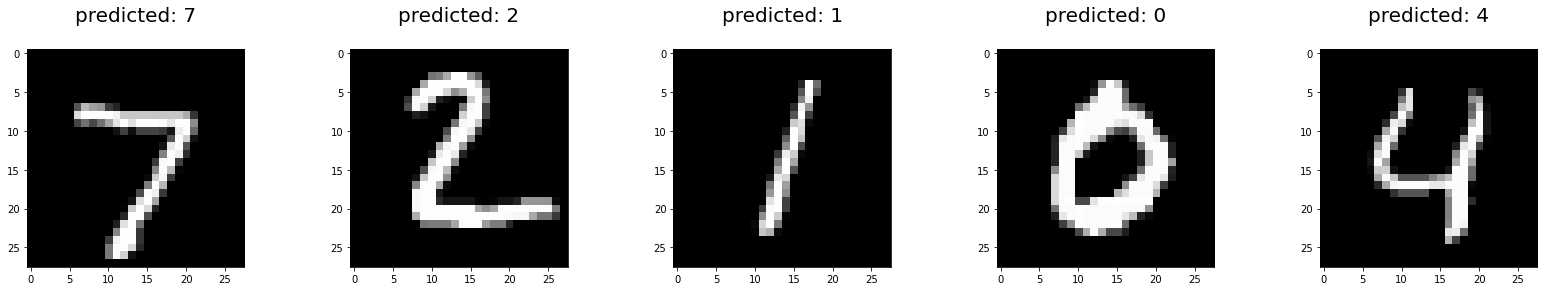

In [111]:
plt.figure(figsize=(28,4))
for index, (image, label) in enumerate(zip(x_test[0:5], y_pred[0:5])):
  plt.subplot(1, 5, index + 1)
  plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
  plt.title('predicted: %i\n' % label, fontsize = 20)

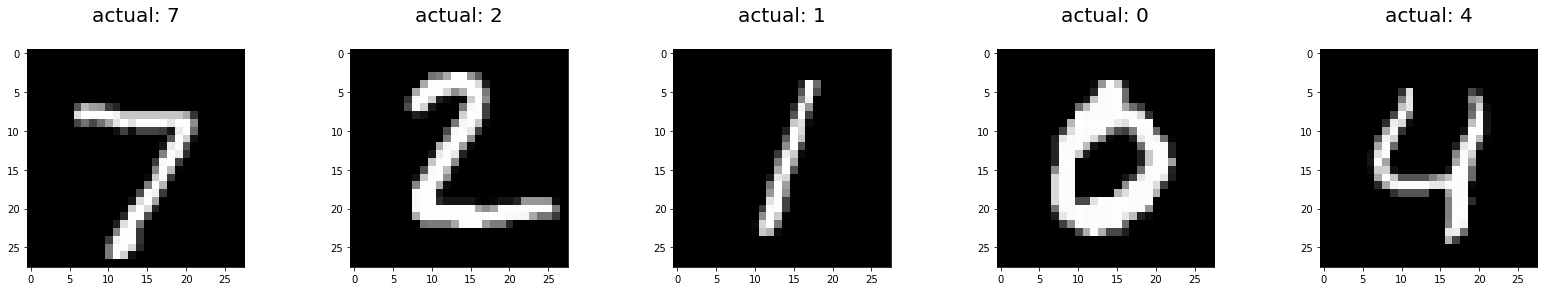

In [112]:
plt.figure(figsize=(28,4))
for index, (image, label) in enumerate(zip(x_test[0:5], y_test[0:5])):
  plt.subplot(1, 5, index + 1)
  plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
  plt.title('actual: %i\n' % label, fontsize = 20)

In [113]:
print('Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Recall Score: {0:0.4f}'.format( metrics.recall_score(y_test, y_pred, average='macro')))
print('Precision Score: {0:0.4f}'.format(metrics.precision_score(y_test, y_pred, average='macro')))
print('F1 Score: {0:0.4f}'.format(metrics.f1_score(y_test, y_pred, average='macro')))

Accuracy Score: 0.9912
Recall Score: 0.9911
Precision Score: 0.9911
F1 Score: 0.9911


# Saving the model

Now that we have a working cnn, we can now save our model. To do this we want move to the correct folder, in this case I have a folder called `saved_models` where I want to save my model to. 

In [114]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/cutie hack 2021/saved_models")
# this moves us into the correct folder that we want to be inside

In [115]:
model.save('mnist_cnn')

INFO:tensorflow:Assets written to: mnist_cnn/assets


# Test if the model works
Now that we saved our model, we want to see if it will work. To do so, let's try and load our model. 

In [116]:
new_model = models.load_model("mnist_cnn")

Since we are able to do this, let's try and compare the predicted values that we get to the original model. `np.testing.assert_allclose` will raise an AssertionError if the two objects are not equal. As such, if we get no error, then we have successfully loaded the original model! 

In [117]:
y_pred_new = new_model.predict(x_test)
y_pred_new = np.argmax(y_pred_new, axis=1)

In [118]:
np.testing.assert_allclose(
    y_pred, y_pred_new
)